In [1]:
import torch
import torch.nn as nn
import pandas as pd
import math
import random
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline

t = 0.5
seed = 42
# MAX_EPOCHS = int(1e6)

# problem setup: min( ||p*a - t||^2 + \lambda*\sum{(p_i)*(1-p_i)*a_i^2})

def get_regularization(n, p, a, lmbda=1.0):
    reg = torch.sum(p * (1-p) * torch.pow(a, 2))
    reg = lmbda * reg 
    return reg

def set_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    print("Seeded everything: {}".format(seed))

set_seed(seed)

Seeded everything: 42


In [2]:
# decide regularizer

def subset_sum(num_samples=10, lmbda=0, lr=0.0001, p_init='uniform', optim_algo='Adam'):
    a = torch.zeros(num_samples)
    p = nn.Parameter(torch.Tensor(a.size()))
    a.requires_grad = False
    p_list = []
    tot_loss_list = []
    subset_loss_list = []
    epoch_list = []
    
    if optim_algo == 'Adam':
        optimizer = optim.Adam(
                    [p],
                    lr=0.01,
                    weight_decay=0)
    else:
        optimizer = optim.SGD(
                    [p],
                    lr=lr,
                    weight_decay=0)

    # initialize a as uniform [-1, 1]
    nn.init.uniform_(a, a=-1, b=1)
    if p_init == 'uniform':
        nn.init.uniform_(p, a=0, b=1)
    else:
        nn.init.normal_(p, mean=0.5)
        p.data = torch.clamp(p.data, 0.0, 1.0)

    # need to increase T for each n
    MAX_EPOCHS = 1000
    # MAX_EPOCHS = int(1e6*math.log(num_samples,10))

    CONVERGED_FLAG=False
    for num_iter in range(MAX_EPOCHS):
        optimizer.zero_grad()
        loss = (t - torch.sum(p*a))**2 + get_regularization(num_samples, p, a, lmbda=lmbda)
        loss.backward()
        optimizer.step()
        # loss we care out is not the total loss. Just the subset sum loss
        subset_loss_list.append(((t - torch.sum(p*a))**2).item())
        # also remember total loss for stopping criterion
        tot_loss_list.append(loss.item())
        epoch_list.append(num_iter)
        p_list.append(p.data)
        if num_iter % 1000 == 0 and num_iter != 0:
            print("Iteration={} | Loss={}".format(num_iter, loss))
        p.data = torch.clamp(p.data, 0.0, 1.0)
        if num_iter > 5 and loss.item() == tot_loss_list[-2]:
            print("Iteration={} | Converged".format(num_iter))
            CONVERGED_FLAG=True
            break

    # by the recent paper, error should be O(1/n^logn)
    min_error = 1.0/(num_samples**np.log(num_samples))
    # print("Minimum Error = {}".format(min_error))
    results_df = pd.DataFrame({'epoch': epoch_list, 'loss': subset_loss_list})
    return min_error, p, results_df, CONVERGED_FLAG

# returns number of vertices which are fractional
def get_num_frac(x, num_samples):
    num_middle = torch.sum(torch.gt(x,
                           torch.ones_like(x)*0) *
                           torch.lt(x,
                           torch.ones_like(x*(1)).int())).item()
    return 1.0*num_middle/num_samples

# returns l2 distance to the nearest vertex
def get_dist_to_vertex(x):
    rounded_x = torch.gt(x, torch.ones_like(x)*0.5).int().float()
    return torch.norm(x-rounded_x).item()

Num Samples = 10



-------------------------------------------------------------------------------------------------------------------
Lambda = 0.004982128296440718 | Converged = False | Error_ratio=1.1097861899805869e-07 | Final error=5.529097180101417e-10 | Minimum error=0.004982128296440718 | num_frac=0.7 | dist_to_veretx=0.9193278551101685
-------------------------------------------------------------------------------------------------------------------



Iteration=630 | Converged



-------------------------------------------------------------------------------------------------------------------
Lambda = 1.0 | Converged = True | Error_ratio=0.7099388987481363 | Final error=0.003537006676197052 | Minimum error=0.004982128296440718 | num_frac=0.0 | dist_to_veretx=0.0
-------------------------------------------------------------------------------------------------------------------



Num Samples = 100.0
Iteration=229 | Converged



------------------------------------------------

<Figure size 432x288 with 0 Axes>

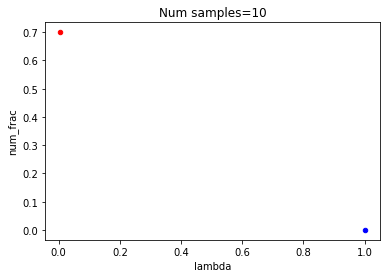

<Figure size 432x288 with 0 Axes>

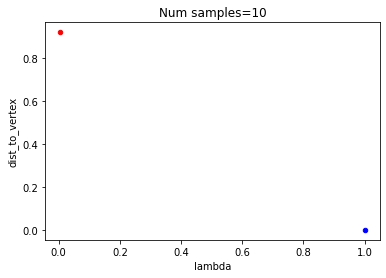

<Figure size 432x288 with 0 Axes>

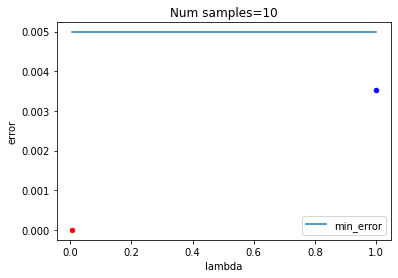

<Figure size 432x288 with 0 Axes>

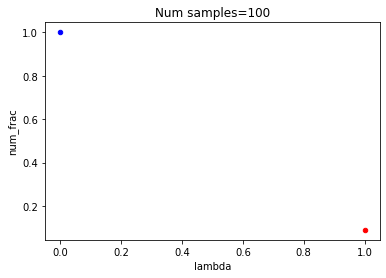

<Figure size 432x288 with 0 Axes>

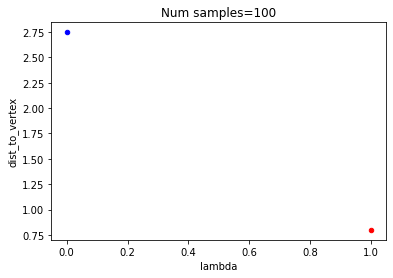

<Figure size 432x288 with 0 Axes>

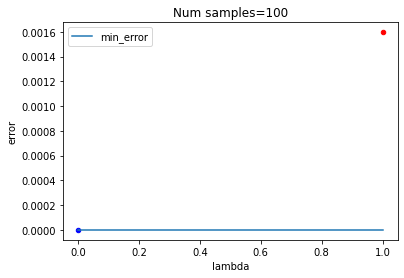

<Figure size 432x288 with 0 Axes>

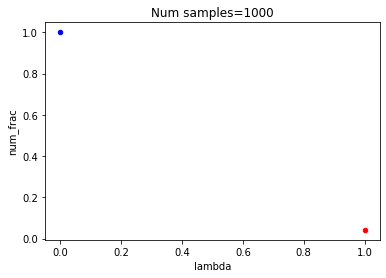

<Figure size 432x288 with 0 Axes>

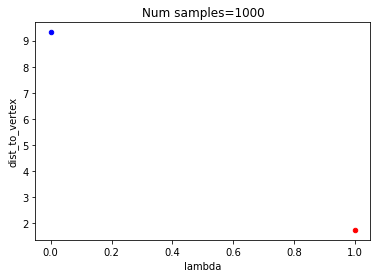

<Figure size 432x288 with 0 Axes>

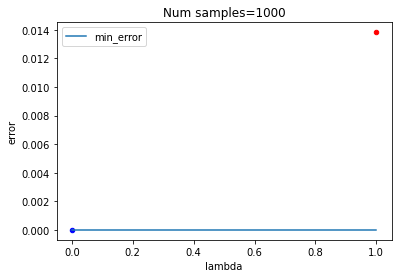

In [4]:
avg_error_ratios = []
df_list = []
for num_samples in [10, 1e2, 1e3]:#, 1e4, 1e5, 1e6, 1e7]:
    print("Num Samples = {}".format(num_samples))
    error_ratio_list = []
    min_error_list = []
    error_list = []
    lmbda_list = []
    num_frac_list = []
    dist_to_vertex_list = []
    converged_flag_list = []
    min_lmbda = 1/(num_samples**math.log(num_samples))
    max_lmbda = 1.0
    lmbda_range = np.linspace(min_lmbda, max_lmbda, 2, endpoint=True)
    for lmbda in lmbda_range:
        num_samples = int(num_samples)
        min_error, p_final, results_df, CONVERGED_FLAG = subset_sum(num_samples, lmbda)
        final_error = results_df.tail(1).loss.item()
        error_list.append(final_error)
        min_error_list.append(min_error)
        lmbda_list.append(lmbda)
        num_frac = get_num_frac(p_final, num_samples)
        num_frac_list.append(num_frac)
        dist_to_vertex = get_dist_to_vertex(p_final)
        dist_to_vertex_list.append(dist_to_vertex)
        error_ratio = 1.0*final_error/min_error
        error_ratio_list.append(error_ratio)
        converged_flag_list.append(CONVERGED_FLAG)
        print("\n\n\n-------------------------------------------------------------------------------------------------------------------")
        print("Lambda = {} | Converged = {} | Error_ratio={} | Final error={} | Minimum error={} | num_frac={} | dist_to_veretx={}".\
                format(lmbda, CONVERGED_FLAG, error_ratio, final_error, min_error, num_frac, dist_to_vertex))
        print("-------------------------------------------------------------------------------------------------------------------\n\n\n")
    
    num_samples_list = [num_samples for x in range(len(lmbda_list))]
    results_df = pd.DataFrame({"num_samples": num_samples_list, "lambda": lmbda_list, "error": error_list,
                                "num_frac": num_frac_list, "dist_to_vertex": dist_to_vertex_list,
                                "min_error": min_error_list, "error_ratio": error_ratio_list,
                                "converged": converged_flag_list})

    results_df['lambda'] = results_df['lambda'].to_numpy()
    results_df['error'] = results_df['error'].to_numpy()
    results_df['num_frac'] = results_df['num_frac'].to_numpy()
    results_df['min_error'] = results_df['min_error'].to_numpy()
    df_list.append(results_df)
    # print for each lambda the non 0-1 for each number of samples
    plt.figure()
    ax = results_df[results_df['converged'] == True].plot(x="lambda", y="num_frac", kind = "scatter", color='blue',
                                                          title="Num samples={}".format(num_samples))
    results_df[results_df['converged'] == False].plot(ax=ax, x="lambda", y="num_frac", kind = "scatter", color='red',
                                                  title="Num samples={}".format(num_samples))
    plt.savefig("lambda_vs_num_frac_num_samples_{}.pdf".format(num_samples), format='pdf', dpi=600, bbox_inches='tight', pad_inches=0.05)
    # plot for each lambda the distance from the vertex for the minimum
    plt.figure()
    ax = results_df[results_df['converged'] == True].plot(x="lambda", y="dist_to_vertex", kind="scatter", color="blue",
                                                        title="Num samples={}".format(num_samples))
    results_df[results_df['converged'] == False].plot(ax=ax, x="lambda", y="dist_to_vertex", kind="scatter", color="red",
                                                        title="Num samples={}".format(num_samples))
    plt.savefig("lambda_vs_dist_to_vertex_num_samples_{}.pdf".format(num_samples), format='pdf', dpi=600, bbox_inches='tight', pad_inches=0.05)
    plt.figure()
    ax = results_df[results_df['converged'] == True].plot(x="lambda", y="error", kind='scatter', color="blue",
                                                          title="Num samples={}".format(num_samples))
    results_df[results_df['converged'] == False].plot(ax=ax, x="lambda", y="error", kind='scatter', color="red",
                                                          title="Num samples={}".format(num_samples))
    # plot the minimum error for different lambdas for each number of samples
    results_df.plot(x="lambda", y="min_error", ax=ax)
    plt.savefig("lambda_vs_error_num_samples_{}.pdf".format(num_samples), format='pdf', dpi=600, bbox_inches='tight', pad_inches=0.05)

combined_results_df = pd.concat(df_list)

In [4]:
num_samples = 100
min_error_list = []
error_list = []
lmbda_list = []
num_frac_list = []
dist_to_vertex_list = []
error_ratio_list = []

for lmbda in [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0]:
    min_error, p_final, results_df = subset_sum(num_samples, lmbda)
    final_error = results_df.tail(1).loss.item()
    num_frac = get_num_frac(p_final, num_samples)
    dist_to_vertex = get_dist_to_vertex(p_final)
    print("Lambda = {} | Error_ratio={} | Final error={} | Minimum error={} | Num fractional coordinates={} | dist_to_veretx={}".\
          format(lmbda, final_error/min_error, final_error, min_error, num_frac, dist_to_vertex))
    error_list.append(final_error)
    min_error_list.append(min_error)
    num_frac_list.append(num_frac)
    dist_to_vertex_list.append(dist_to_vertex)
    lmbda_list.append(lmbda)
    error_ratio_list.append(final_error/min_error)

Lambda = 1e-06 | Error_ratio=0.17659429833067308 | Final error=1.0880185641326534e-10 | Minimum error=6.161119438269389e-10 | Num fractional coordinates=1.0 | dist_to_veretx=2.074002265930176
Lambda = 1e-05 | Error_ratio=0.08442504887704112 | Final error=5.2015280971318134e-11 | Minimum error=6.161119438269389e-10 | Num fractional coordinates=1.0 | dist_to_veretx=1.7375987768173218
Lambda = 0.0001 | Error_ratio=1542079.5254123025 | Final error=0.0009500936139374971 | Minimum error=6.161119438269389e-10 | Num fractional coordinates=0.01 | dist_to_veretx=0.472167432308197
Iteration=100000 | Loss=1.1880521455509552e-08
Lambda = 0.001 | Error_ratio=978194.2705141767 | Final error=0.0006026771734468639 | Minimum error=6.161119438269389e-10 | Num fractional coordinates=0.01 | dist_to_veretx=0.0050104898400604725
Lambda = 0.01 | Error_ratio=135065.53778913777 | Final error=8.321549103129655e-05 | Minimum error=6.161119438269389e-10 | Num fractional coordinates=0.01 | dist_to_veretx=0.23925790

In [10]:
results_df = pd.DataFrame({"lambda": lmbda_list, "error": error_list,
                          "num_frac": num_frac_list, "dist_to_vertex": dist_to_vertex_list,
                          "min_error": min_error_list, "error_ratio": error_ratio_list})

In [20]:
results_df['log_error'] = np.log(results_df['error'])
results_df['log_lambda'] = np.log(results_df['lambda'])
results_df['log_min_error'] = np.log(results_df['min_error'])

/Users/kartik/ml_workspace/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='log_lambda', ylabel='log_error'>

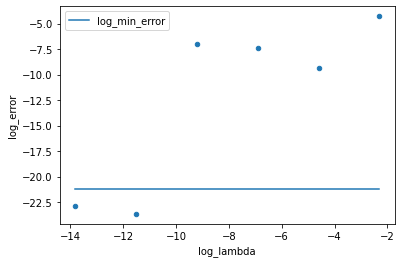

In [22]:
ax = results_df.plot(x="log_lambda", y="log_error", kind='scatter')
results_df.plot(x="log_lambda", y="log_min_error", ax=ax)

<AxesSubplot:xlabel='log_lambda', ylabel='num_frac'>

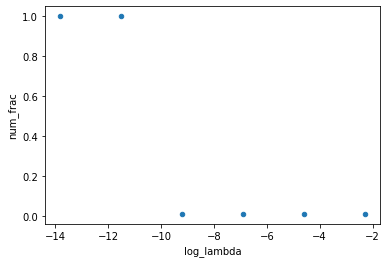

In [23]:
results_df.plot(x="log_lambda", y="num_frac", kind="scatter")

<AxesSubplot:xlabel='log_lambda', ylabel='dist_to_vertex'>

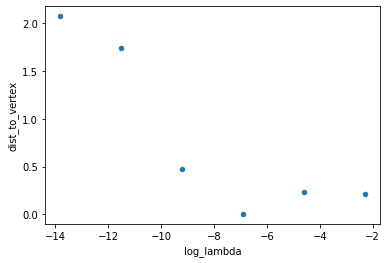

In [24]:
results_df.plot(x="log_lambda", y="dist_to_vertex", kind="scatter")

# Binary search to find optimal lambda (if it exists)

In [4]:
num_samples = 100
min_error_list = []
error_list = []
lmbda_list = []
num_frac_list = []
dist_to_vertex_list = []
error_ratio_list = []
l_min = 1e-5
l_max = 1e-4

for i in range(10):
    lmbda = (l_min + l_max)/2
    min_error, p_final, results_df = subset_sum(num_samples, lmbda)
    final_error = results_df.tail(1).loss.item()
    num_frac = get_num_frac(p_final, num_samples)
    dist_to_vertex = get_dist_to_vertex(p_final)
    print("Lambda = {} | Error_ratio={} | Final error={} | Minimum error={} | Num fractional coordinates={} | dist_to_veretx={}".\
          format(lmbda, final_error/min_error, final_error, min_error, num_frac, dist_to_vertex))
    error_list.append(final_error)
    min_error_list.append(min_error)
    num_frac_list.append(num_frac)
    dist_to_vertex_list.append(dist_to_vertex)
    lmbda_list.append(lmbda)
    error_ratio_list.append(final_error/min_error)
    if final_error < min_error or num_frac > 0.5:
        l_min = lmbda
    else:
        l_max = lmbda

Lambda = 5.5e-05 | Error_ratio=5017602.635312105 | Final error=0.003091404912993312 | Minimum error=6.161119438269389e-10 | Num fractional coordinates=0.01 | dist_to_veretx=0.0238798800855875
Iteration=100000 | Loss=7.93205344962189e-06
Lambda = 3.2500000000000004e-05 | Error_ratio=308.29958885512036 | Final error=1.899470589705743e-07 | Minimum error=6.161119438269389e-10 | Num fractional coordinates=0.06 | dist_to_veretx=0.5977756977081299
Lambda = 2.125e-05 | Error_ratio=13.357644622832028 | Final error=8.2298043935225e-09 | Minimum error=6.161119438269389e-10 | Num fractional coordinates=1.0 | dist_to_veretx=1.7004562616348267
Iteration=100000 | Loss=0.0001420225016772747
Iteration=200000 | Loss=9.130993561257128e-08
Lambda = 2.6875000000000003e-05 | Error_ratio=11144.368289937545 | Final error=6.866178409836721e-06 | Minimum error=6.161119438269389e-10 | Num fractional coordinates=0.04 | dist_to_veretx=0.41415953636169434
Lambda = 2.4062500000000002e-05 | Error_ratio=17.1385905382

<AxesSubplot:xlabel='log_lambda', ylabel='log_error'>

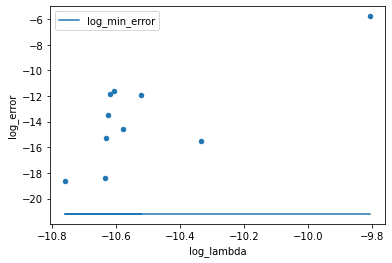

In [5]:
results_df = pd.DataFrame({"lambda": lmbda_list, "error": error_list,
                          "num_frac": num_frac_list, "dist_to_vertex": dist_to_vertex_list,
                          "min_error": min_error_list, "error_ratio": error_ratio_list})
results_df['log_error'] = np.log(results_df['error'])
results_df['log_lambda'] = np.log(results_df['lambda'])
results_df['log_min_error'] = np.log(results_df['min_error'])

ax = results_df.plot(x="log_lambda", y="log_error", kind='scatter')
results_df.plot(x="log_lambda", y="log_min_error", ax=ax)

<AxesSubplot:xlabel='log_lambda', ylabel='num_frac'>

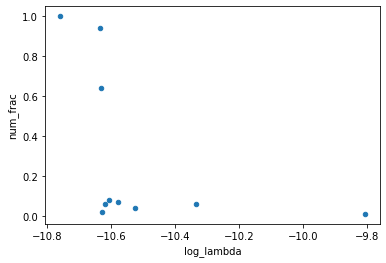

In [6]:
results_df.plot(x="log_lambda", y="num_frac", kind="scatter")

<AxesSubplot:xlabel='log_lambda', ylabel='dist_to_vertex'>

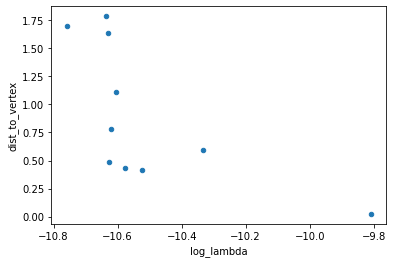

In [7]:
results_df.plot(x="log_lambda", y="dist_to_vertex", kind="scatter")

## $2.5\cdot10^{-5}$ doesn't look too bad!

## Lambda=0

In [17]:
num_samples = 100
min_error_list = []
error_list = []
lmbda_list = []
num_frac_list = []
dist_to_vertex_list = []
error_ratio_list = []

for i in range(1):
    lmbda = -1
    min_error, p_final, results_df = subset_sum(num_samples, lmbda)
    final_error = results_df.tail(1).loss.item()
    num_frac = get_num_frac(p_final, num_samples)
    dist_to_vertex = get_dist_to_vertex(p_final)
    print("Lambda = {} | Error_ratio={} | Final error={} | Minimum error={} | Num fractional coordinates={} | dist_to_veretx={}".\
          format(lmbda, final_error/min_error, final_error, min_error, num_frac, dist_to_vertex))
    error_list.append(final_error)
    min_error_list.append(min_error)
    num_frac_list.append(num_frac)
    dist_to_vertex_list.append(dist_to_vertex)
    lmbda_list.append(lmbda)
    error_ratio_list.append(final_error/min_error)
    if final_error < min_error or num_frac > 0.5:
        l_min = lmbda
    else:
        l_max = lmbda

Lambda = -1 | Error_ratio=0.8502820850497218 | Final error=5.238689482212067e-10 | Minimum error=6.161119438269389e-10 | Num fractional coordinates=1.0 | dist_to_veretx=1.8306583166122437
